# Spark imageprocessing

Proces a directory with images

In [2]:
from typing import Iterator
import time
from sklearn.preprocessing import OrdinalEncoder
import urllib
import statistics
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType
from pyspark.sql import Row
from pyspark import StorageLevel
from operator import add
import numpy as np
from io import BytesIO
import seaborn as sns
from PIL import Image, ImageDraw
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
import gc
from sklearn.model_selection import train_test_split
import os
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

In [3]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# create a configuration object
config = tf.config.experimental.set_memory_growth(
    tf.config.list_physical_devices('GPU')[0], True)

# create a TensorFlow session using the configuration object
sess = tf.compat.v1.Session(config=config)

# set the TensorFlow backend's session to the newly created session
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
image_dir = "hdfs://localhost:9000/user1/Animals/Train/*"
image_df = spark.read.format("binaryFile").option(
    "pathGlobFilter", "*.jpg").load(image_dir).orderBy("path")

In [6]:
image_df.schema

StructType([StructField('path', StringType(), True), StructField('modificationTime', TimestampType(), True), StructField('length', LongType(), True), StructField('content', BinaryType(), True)])

In [7]:
#create an index column for future join
image_df = image_df.withColumn("columnindex",
                               row_number().over(Window().orderBy("path")))

In [8]:
image_df.show()

+--------------------+--------------------+------+--------------------+-----------+
|                path|    modificationTime|length|             content|columnindex|
+--------------------+--------------------+------+--------------------+-----------+
|hdfs://localhost:...|2023-04-07 20:49:...| 27340|[FF D8 FF E0 00 1...|          1|
|hdfs://localhost:...|2023-04-07 20:49:...| 35903|[FF D8 FF E0 00 1...|          2|
|hdfs://localhost:...|2023-04-07 20:49:...| 44470|[FF D8 FF E0 00 1...|          3|
|hdfs://localhost:...|2023-04-07 20:49:...| 41022|[FF D8 FF E0 00 1...|          4|
|hdfs://localhost:...|2023-04-07 20:49:...| 47317|[FF D8 FF E0 00 1...|          5|
|hdfs://localhost:...|2023-04-07 20:49:...| 31429|[FF D8 FF E0 00 1...|          6|
|hdfs://localhost:...|2023-04-07 20:49:...| 51305|[FF D8 FF E0 00 1...|          7|
|hdfs://localhost:...|2023-04-07 20:49:...| 44227|[FF D8 FF E0 00 1...|          8|
|hdfs://localhost:...|2023-04-07 20:49:...| 36102|[FF D8 FF E0 00 1...|     

In [9]:
image_df2 = image_df.select("path").collect()

In [10]:
#loop to get labels and filename per row
i = 0
target = []
for row in image_df2:
    subdirname = os.path.basename(os.path.dirname(image_df2[i][0]))
    name = os.path.basename(image_df2[i][0]).split('/')[-1]
    target.append([subdirname, name])
    i = i + 1

In [11]:
target

[['cat', 'flickr_cat_000002.jpg'],
 ['cat', 'flickr_cat_000003.jpg'],
 ['cat', 'flickr_cat_000004.jpg'],
 ['cat', 'flickr_cat_000005.jpg'],
 ['cat', 'flickr_cat_000006.jpg'],
 ['cat', 'flickr_cat_000007.jpg'],
 ['cat', 'flickr_cat_000009.jpg'],
 ['cat', 'flickr_cat_000010.jpg'],
 ['cat', 'flickr_cat_000012.jpg'],
 ['cat', 'flickr_cat_000013.jpg'],
 ['cat', 'flickr_cat_000014.jpg'],
 ['cat', 'flickr_cat_000015.jpg'],
 ['cat', 'flickr_cat_000017.jpg'],
 ['cat', 'flickr_cat_000018.jpg'],
 ['cat', 'flickr_cat_000019.jpg'],
 ['cat', 'flickr_cat_000020.jpg'],
 ['cat', 'flickr_cat_000021.jpg'],
 ['cat', 'flickr_cat_000022.jpg'],
 ['cat', 'flickr_cat_000023.jpg'],
 ['cat', 'flickr_cat_000024.jpg'],
 ['cat', 'flickr_cat_000025.jpg'],
 ['cat', 'flickr_cat_000026.jpg'],
 ['cat', 'flickr_cat_000027.jpg'],
 ['cat', 'flickr_cat_000028.jpg'],
 ['cat', 'flickr_cat_000029.jpg'],
 ['cat', 'flickr_cat_000030.jpg'],
 ['cat', 'flickr_cat_000031.jpg'],
 ['cat', 'flickr_cat_000032.jpg'],
 ['cat', 'flickr_cat

In [12]:
dfschema = ['target', 'filename']
df1 = sqlContext.createDataFrame(data=target, schema=dfschema)

In [13]:
df1.printSchema()
df1.show(10000, truncate=False)

root
 |-- target: string (nullable = true)
 |-- filename: string (nullable = true)

+------+----------------------+
|target|filename              |
+------+----------------------+
|cat   |flickr_cat_000002.jpg |
|cat   |flickr_cat_000003.jpg |
|cat   |flickr_cat_000004.jpg |
|cat   |flickr_cat_000005.jpg |
|cat   |flickr_cat_000006.jpg |
|cat   |flickr_cat_000007.jpg |
|cat   |flickr_cat_000009.jpg |
|cat   |flickr_cat_000010.jpg |
|cat   |flickr_cat_000012.jpg |
|cat   |flickr_cat_000013.jpg |
|cat   |flickr_cat_000014.jpg |
|cat   |flickr_cat_000015.jpg |
|cat   |flickr_cat_000017.jpg |
|cat   |flickr_cat_000018.jpg |
|cat   |flickr_cat_000019.jpg |
|cat   |flickr_cat_000020.jpg |
|cat   |flickr_cat_000021.jpg |
|cat   |flickr_cat_000022.jpg |
|cat   |flickr_cat_000023.jpg |
|cat   |flickr_cat_000024.jpg |
|cat   |flickr_cat_000025.jpg |
|cat   |flickr_cat_000026.jpg |
|cat   |flickr_cat_000027.jpg |
|cat   |flickr_cat_000028.jpg |
|cat   |flickr_cat_000029.jpg |
|cat   |flickr_cat_0

In [14]:
df = df1.withColumn("columnindex",
                    row_number().over(Window().orderBy("target")))

In [15]:
df.show(100)

+------+--------------------+-----------+
|target|            filename|columnindex|
+------+--------------------+-----------+
|   cat|flickr_cat_000002...|          1|
|   cat|flickr_cat_000003...|          2|
|   cat|flickr_cat_000004...|          3|
|   cat|flickr_cat_000005...|          4|
|   cat|flickr_cat_000006...|          5|
|   cat|flickr_cat_000007...|          6|
|   cat|flickr_cat_000009...|          7|
|   cat|flickr_cat_000010...|          8|
|   cat|flickr_cat_000012...|          9|
|   cat|flickr_cat_000013...|         10|
|   cat|flickr_cat_000014...|         11|
|   cat|flickr_cat_000015...|         12|
|   cat|flickr_cat_000017...|         13|
|   cat|flickr_cat_000018...|         14|
|   cat|flickr_cat_000019...|         15|
|   cat|flickr_cat_000020...|         16|
|   cat|flickr_cat_000021...|         17|
|   cat|flickr_cat_000022...|         18|
|   cat|flickr_cat_000023...|         19|
|   cat|flickr_cat_000024...|         20|
|   cat|flickr_cat_000025...|     

In [16]:
print('number of images: %s' % image_df.count())
print('number of labels and filenames: %s' % df.count())

number of images: 14630
number of labels and filenames: 14630


In [17]:
image_df3 = image_df.join(df, on='columnindex')

In [18]:
image_df = image_df3

In [19]:
image_df.show()

+-----------+--------------------+--------------------+------+--------------------+------+--------------------+
|columnindex|                path|    modificationTime|length|             content|target|            filename|
+-----------+--------------------+--------------------+------+--------------------+------+--------------------+
|          1|hdfs://localhost:...|2023-04-07 20:49:...| 27340|[FF D8 FF E0 00 1...|   cat|flickr_cat_000002...|
|          2|hdfs://localhost:...|2023-04-07 20:49:...| 35903|[FF D8 FF E0 00 1...|   cat|flickr_cat_000003...|
|          3|hdfs://localhost:...|2023-04-07 20:49:...| 44470|[FF D8 FF E0 00 1...|   cat|flickr_cat_000004...|
|          4|hdfs://localhost:...|2023-04-07 20:49:...| 41022|[FF D8 FF E0 00 1...|   cat|flickr_cat_000005...|
|          5|hdfs://localhost:...|2023-04-07 20:49:...| 47317|[FF D8 FF E0 00 1...|   cat|flickr_cat_000006...|
|          6|hdfs://localhost:...|2023-04-07 20:49:...| 31429|[FF D8 FF E0 00 1...|   cat|flickr_cat_000

In [20]:
del image_df3
gc.collect()

20

In [21]:
#verify with random samples that the correct lables are joined accurately
image_df.select("path", "target", "filename").rdd.takeSample(0, 30)

[Row(path='hdfs://localhost:9000/user1/Animals/Train/dog/pixabay_dog_002161.jpg', target='dog', filename='pixabay_dog_002161.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/cat/pixabay_cat_003478.jpg', target='cat', filename='pixabay_cat_003478.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/wild/flickr_wild_000291.jpg', target='wild', filename='flickr_wild_000291.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/dog/flickr_dog_000771.jpg', target='dog', filename='flickr_dog_000771.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/wild/flickr_wild_001231.jpg', target='wild', filename='flickr_wild_001231.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/dog/pixabay_dog_003988.jpg', target='dog', filename='pixabay_dog_003988.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/cat/pixabay_cat_001061.jpg', target='cat', filename='pixabay_cat_001061.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Train/wild/flickr_wild_0018

In [22]:
image_df.dtypes

[('columnindex', 'int'),
 ('path', 'string'),
 ('modificationTime', 'timestamp'),
 ('length', 'bigint'),
 ('content', 'binary'),
 ('target', 'string'),
 ('filename', 'string')]

In [23]:
print('Count of rows: {0}'.format(image_df.count()))
print('Count of distinct rows: {0}'.format(image_df.distinct().count()))

Count of rows: 14630
Count of distinct rows: 14630


In [24]:
targetRDD = sc.parallelize([row[0] for row in target])

In [25]:
labelcount = targetRDD.map(lambda w: (w, 1))

In [26]:
labelcount = labelcount.reduceByKey(add)

In [27]:
labelcount.take(50)

[('dog', 4739), ('cat', 5153), ('wild', 4738)]

In [28]:
data = image_df.groupby('target').count()
data.show()

+------+-----+
|target|count|
+------+-----+
|   cat| 5153|
|   dog| 4739|
|  wild| 4738|
+------+-----+



In [29]:
data = data.toPandas()

C:\Users\krist\AppData\Local\Temp\ipykernel_18864\1827647124.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='target', y='count',data=data, ci = None, estimator=sum)


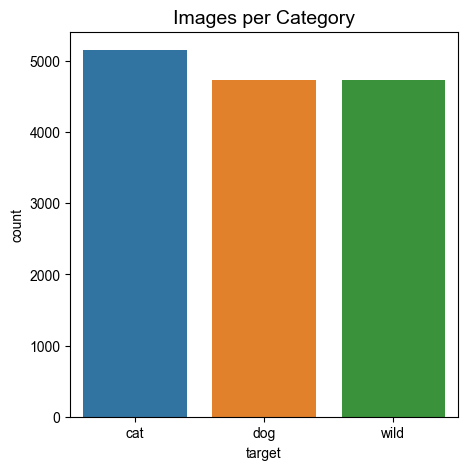

In [30]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='target', y='count', data=data, ci=None, estimator=sum)
plt.title('Images per Category', fontsize=14)
sns.set_style("darkgrid")

In [31]:
image_df = image_df.drop("columnindex", "modificationTime", "length")

In [32]:
gc.collect()

56

In [33]:
rows = image_df.select('content').orderBy("path").collect()

In [34]:
row = image_df.select('content').orderBy('path').first()
# Extract the binary data from the 'content' field of the Row object and store it in a BytesIO object.
binary_data = BytesIO(row['content'])
# Create a PIL.Image object.
img = Image.open(binary_data)

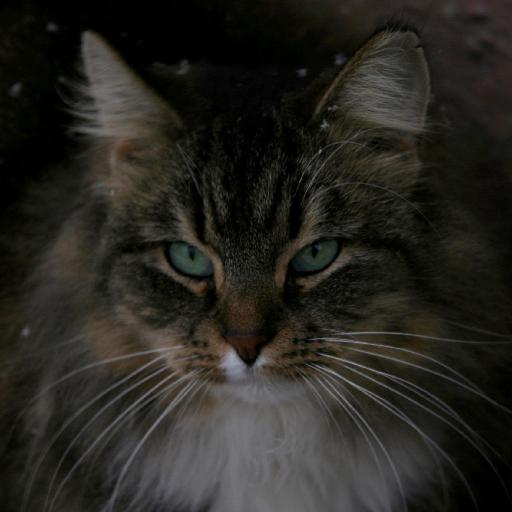

In [35]:
display(img)

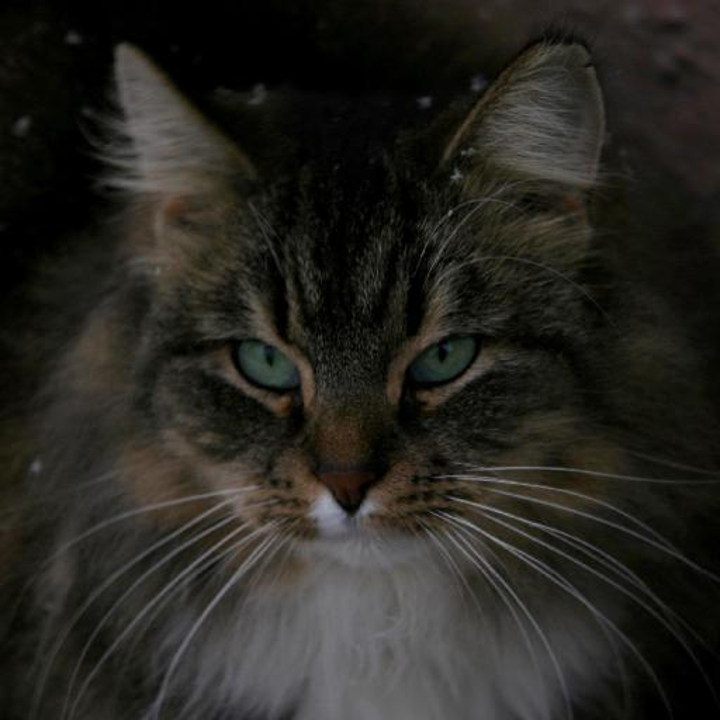

In [36]:
display(img.resize((720, 720)))

In [37]:
def process_row(row):
    binary_data = BytesIO(row.content)
    img = Image.open(binary_data)
    img = img.resize((76, 76))
    return np.array(img)

In [38]:
numpy_arrays = list(map(process_row, rows))

In [39]:
numpy_arrays

[array([[[ 1,  1,  1],
         [ 2,  2,  1],
         [ 1,  1,  0],
         ...,
         [55, 43, 40],
         [52, 42, 41],
         [50, 40, 39]],
 
        [[ 4,  4,  1],
         [ 5,  6,  2],
         [ 4,  5,  0],
         ...,
         [52, 43, 39],
         [52, 42, 41],
         [50, 40, 39]],
 
        [[ 6,  7,  1],
         [ 7,  8,  2],
         [ 7,  8,  1],
         ...,
         [49, 43, 40],
         [52, 42, 41],
         [52, 42, 41]],
 
        ...,
 
        [[17, 18, 12],
         [20, 21, 15],
         [24, 25, 19],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 4,  4,  4]],
 
        [[14, 15,  9],
         [18, 19, 13],
         [21, 22, 16],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 1,  1,  1]],
 
        [[11, 12,  6],
         [16, 17, 11],
         [23, 24, 18],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]], dtype=uint8),
 array([[[181, 168, 166],
         [197, 1

In [40]:
numpy_array = np.stack(numpy_arrays)

In [41]:
del numpy_arrays, rows
gc.collect()

52

In [42]:
numpy_array

array([[[[  1,   1,   1],
         [  2,   2,   1],
         [  1,   1,   0],
         ...,
         [ 55,  43,  40],
         [ 52,  42,  41],
         [ 50,  40,  39]],

        [[  4,   4,   1],
         [  5,   6,   2],
         [  4,   5,   0],
         ...,
         [ 52,  43,  39],
         [ 52,  42,  41],
         [ 50,  40,  39]],

        [[  6,   7,   1],
         [  7,   8,   2],
         [  7,   8,   1],
         ...,
         [ 49,  43,  40],
         [ 52,  42,  41],
         [ 52,  42,  41]],

        ...,

        [[ 17,  18,  12],
         [ 20,  21,  15],
         [ 24,  25,  19],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  4,   4,   4]],

        [[ 14,  15,   9],
         [ 18,  19,  13],
         [ 21,  22,  16],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  1,   1,   1]],

        [[ 11,  12,   6],
         [ 16,  17,  11],
         [ 23,  24,  18],
         ...,
         [  0,   0,   0],
        

In [43]:
encoder = OrdinalEncoder()
labels = encoder.fit_transform(image_df.select("target").collect())

In [44]:
labels

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]])

In [45]:
n_classes = 3
print("Shape before one-hot encoding: ", labels.shape)
labels = np_utils.to_categorical(labels, n_classes)
print("Shape after one-hot encoding: ", labels.shape)

Shape before one-hot encoding:  (14630, 1)
Shape after one-hot encoding:  (14630, 3)


In [46]:
X = numpy_array.reshape(numpy_array.shape[0], 76, 76, 3)
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=10)

In [47]:
X.shape

(14630, 76, 76, 3)

# CNN Implementation

## Simplest

In [48]:
# Define a custom callback to track the time per epoch
class TimeHistory(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        # Initialize an empty list to store the times per epoch
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        # Record the start time of the current epoch
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        # Calculate the duration of the current epoch
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - self.epoch_time_start
        # Append the epoch duration to the list of times
        self.times.append(epoch_time)

In [49]:
my_model1 = Sequential()
# convolutional layer
my_model1.add(
    Conv2D(25,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           input_shape=(76, 76, 3)))
my_model1.add(MaxPool2D(pool_size=(2, 2)))
# flatten output of conv
my_model1.add(Flatten())
# hidden layer
my_model1.add(Dense(38, activation='relu'))
# output layer
my_model1.add(Dense(3, activation='softmax'))

In [50]:
tf.random.set_seed(100)
my_model1.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
my_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 74, 74, 25)        700       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 25)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 34225)             0         
                                                                 
 dense (Dense)               (None, 38)                1300588   
                                                                 
 dense_1 (Dense)             (None, 3)                 117       
                                                                 
Total params: 1,301,405
Trainable params: 1,301,405
Non-trainable params: 0
______________________________________________

In [51]:
time_callback1 = TimeHistory()

In [52]:
history1 = my_model1.fit((X_train),
                         Y_train,
                         shuffle=True,
                         verbose=1,
                         epochs=50,
                         validation_steps=10,
                         batch_size=32,
                         validation_data=(X_test, Y_test),
                         callbacks=time_callback1)

Epoch 1/50
366/366 [==============================] - 11s 19ms/step - loss: 11.6998 - accuracy: 0.7937 - val_loss: 0.4263 - val_accuracy: 0.8844
Epoch 2/50
366/366 [==============================] - 7s 19ms/step - loss: 0.2820 - accuracy: 0.9221 - val_loss: 0.6124 - val_accuracy: 0.8750
Epoch 3/50
366/366 [==============================] - 7s 18ms/step - loss: 0.1267 - accuracy: 0.9614 - val_loss: 0.5665 - val_accuracy: 0.8906
Epoch 4/50
366/366 [==============================] - 7s 18ms/step - loss: 0.1308 - accuracy: 0.9657 - val_loss: 0.7954 - val_accuracy: 0.8687
Epoch 5/50
366/366 [==============================] - 7s 19ms/step - loss: 0.1067 - accuracy: 0.9720 - val_loss: 0.6079 - val_accuracy: 0.8781
Epoch 6/50
366/366 [==============================] - 7s 18ms/step - loss: 0.1225 - accuracy: 0.9675 - val_loss: 0.5048 - val_accuracy: 0.8844
Epoch 7/50
366/366 [==============================] - 7s 18ms/step - loss: 0.0798 - accuracy: 0.9789 - val_loss: 0.5233 - val_accuracy: 0.90

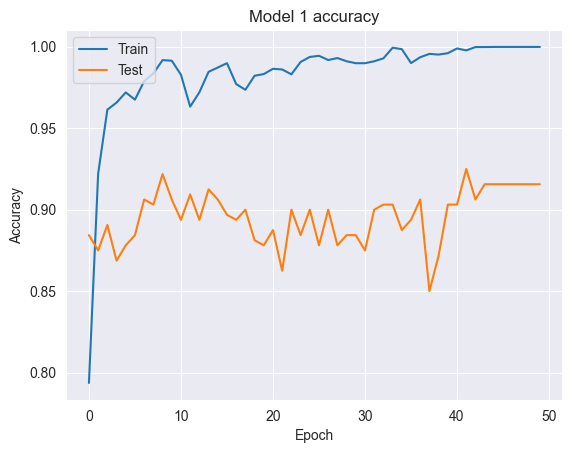

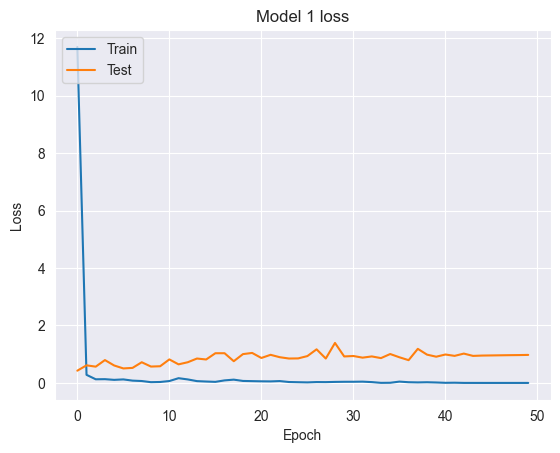

In [53]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
print("Max Accuracy:", max(history1.history['accuracy']))
print("Max Validated Accuracy:", max(history1.history['val_accuracy']))
print("Mean Accuracy:", statistics.mean(history1.history['accuracy']))
print("Mean Validated Accuracy:",
      statistics.mean(history1.history['val_accuracy']))
print("Mean Loss:", statistics.mean(history1.history['loss']))
print("Mean Validated Loss:", statistics.mean(history1.history['val_loss']))

Max Accuracy: 0.9999145865440369
Max Validated Accuracy: 0.925000011920929
Mean Accuracy: 0.9832638430595398
Mean Validated Accuracy: 0.8956249940395355
Mean Loss: 0.2830194205378939
Mean Validated Loss: 0.8681001496315003


In [55]:
predictions = my_model1.predict(X_test[:10])

In [56]:
import numpy as np

print(np.argmax(predictions, axis=1))

[0 1 0 2 1 2 0 1 1 0]


In [57]:
pd.DataFrame(data=Y_test[:10]).idxmax(axis=1)

0    0
1    1
2    0
3    2
4    1
5    2
6    0
7    1
8    1
9    0
dtype: int64

In [58]:
image_dir_val = "hdfs://localhost:9000/user1/Animals/Val/*"
image_df_val = spark.read.format("binaryFile").option(
    "pathGlobFilter", "*.jpg").load(image_dir_val).orderBy("path")

In [59]:
image_df_val = image_df_val.withColumn(
    "columnindex",
    row_number().over(Window().orderBy("path")))

In [60]:
image_df_val.show()

+--------------------+--------------------+------+--------------------+-----------+
|                path|    modificationTime|length|             content|columnindex|
+--------------------+--------------------+------+--------------------+-----------+
|hdfs://localhost:...|2023-04-07 21:01:...| 33184|[FF D8 FF E0 00 1...|          1|
|hdfs://localhost:...|2023-04-07 21:01:...| 47918|[FF D8 FF E0 00 1...|          2|
|hdfs://localhost:...|2023-04-07 21:01:...| 18098|[FF D8 FF E0 00 1...|          3|
|hdfs://localhost:...|2023-04-07 21:01:...| 42041|[FF D8 FF E0 00 1...|          4|
|hdfs://localhost:...|2023-04-07 21:01:...| 52195|[FF D8 FF E0 00 1...|          5|
|hdfs://localhost:...|2023-04-07 21:01:...| 50875|[FF D8 FF E0 00 1...|          6|
|hdfs://localhost:...|2023-04-07 21:01:...| 39808|[FF D8 FF E0 00 1...|          7|
|hdfs://localhost:...|2023-04-07 21:01:...| 40376|[FF D8 FF E0 00 1...|          8|
|hdfs://localhost:...|2023-04-07 21:01:...| 51622|[FF D8 FF E0 00 1...|     

In [61]:
image_df2_val = image_df_val.select("path").collect()

In [62]:
i = 0
target_val = []
for row in image_df2_val:
    subdirname = os.path.basename(os.path.dirname(image_df2_val[i][0]))
    name = os.path.basename(image_df2_val[i][0]).split('/')[-1]
    target_val.append([subdirname, name])
    i = i + 1

In [63]:
target_val

[['cat', 'flickr_cat_000008.jpg'],
 ['cat', 'flickr_cat_000011.jpg'],
 ['cat', 'flickr_cat_000016.jpg'],
 ['cat', 'flickr_cat_000056.jpg'],
 ['cat', 'flickr_cat_000076.jpg'],
 ['cat', 'flickr_cat_000080.jpg'],
 ['cat', 'flickr_cat_000096.jpg'],
 ['cat', 'flickr_cat_000108.jpg'],
 ['cat', 'flickr_cat_000123.jpg'],
 ['cat', 'flickr_cat_000136.jpg'],
 ['cat', 'flickr_cat_000152.jpg'],
 ['cat', 'flickr_cat_000162.jpg'],
 ['cat', 'flickr_cat_000165.jpg'],
 ['cat', 'flickr_cat_000174.jpg'],
 ['cat', 'flickr_cat_000175.jpg'],
 ['cat', 'flickr_cat_000176.jpg'],
 ['cat', 'flickr_cat_000177.jpg'],
 ['cat', 'flickr_cat_000180.jpg'],
 ['cat', 'flickr_cat_000182.jpg'],
 ['cat', 'flickr_cat_000183.jpg'],
 ['cat', 'flickr_cat_000184.jpg'],
 ['cat', 'flickr_cat_000191.jpg'],
 ['cat', 'flickr_cat_000208.jpg'],
 ['cat', 'flickr_cat_000216.jpg'],
 ['cat', 'flickr_cat_000226.jpg'],
 ['cat', 'flickr_cat_000230.jpg'],
 ['cat', 'flickr_cat_000232.jpg'],
 ['cat', 'flickr_cat_000233.jpg'],
 ['cat', 'flickr_cat

In [64]:
dfschema_val = ['target', 'filename']
df1_val = sqlContext.createDataFrame(data=target_val, schema=dfschema_val)

In [65]:
df1_val.printSchema()
df1_val.show(10000, truncate=False)

root
 |-- target: string (nullable = true)
 |-- filename: string (nullable = true)

+------+-----------------------+
|target|filename               |
+------+-----------------------+
|cat   |flickr_cat_000008.jpg  |
|cat   |flickr_cat_000011.jpg  |
|cat   |flickr_cat_000016.jpg  |
|cat   |flickr_cat_000056.jpg  |
|cat   |flickr_cat_000076.jpg  |
|cat   |flickr_cat_000080.jpg  |
|cat   |flickr_cat_000096.jpg  |
|cat   |flickr_cat_000108.jpg  |
|cat   |flickr_cat_000123.jpg  |
|cat   |flickr_cat_000136.jpg  |
|cat   |flickr_cat_000152.jpg  |
|cat   |flickr_cat_000162.jpg  |
|cat   |flickr_cat_000165.jpg  |
|cat   |flickr_cat_000174.jpg  |
|cat   |flickr_cat_000175.jpg  |
|cat   |flickr_cat_000176.jpg  |
|cat   |flickr_cat_000177.jpg  |
|cat   |flickr_cat_000180.jpg  |
|cat   |flickr_cat_000182.jpg  |
|cat   |flickr_cat_000183.jpg  |
|cat   |flickr_cat_000184.jpg  |
|cat   |flickr_cat_000191.jpg  |
|cat   |flickr_cat_000208.jpg  |
|cat   |flickr_cat_000216.jpg  |
|cat   |flickr_cat_000226

In [66]:
df_val = df1_val.withColumn("columnindex",
                            row_number().over(Window().orderBy("target")))
#df2 = df2.withColumn("columnindex",
#                   row_number().over(Window()))#.orderBy("filename")

In [67]:
df_val.show(100)

+------+--------------------+-----------+
|target|            filename|columnindex|
+------+--------------------+-----------+
|   cat|flickr_cat_000008...|          1|
|   cat|flickr_cat_000011...|          2|
|   cat|flickr_cat_000016...|          3|
|   cat|flickr_cat_000056...|          4|
|   cat|flickr_cat_000076...|          5|
|   cat|flickr_cat_000080...|          6|
|   cat|flickr_cat_000096...|          7|
|   cat|flickr_cat_000108...|          8|
|   cat|flickr_cat_000123...|          9|
|   cat|flickr_cat_000136...|         10|
|   cat|flickr_cat_000152...|         11|
|   cat|flickr_cat_000162...|         12|
|   cat|flickr_cat_000165...|         13|
|   cat|flickr_cat_000174...|         14|
|   cat|flickr_cat_000175...|         15|
|   cat|flickr_cat_000176...|         16|
|   cat|flickr_cat_000177...|         17|
|   cat|flickr_cat_000180...|         18|
|   cat|flickr_cat_000182...|         19|
|   cat|flickr_cat_000183...|         20|
|   cat|flickr_cat_000184...|     

In [68]:
print('number of images: %s' % image_df_val.count())
print('number of labels and filenames: %s' % df_val.count())

number of images: 1500
number of labels and filenames: 1500


In [69]:
image_df3 = image_df_val.join(df_val, on='columnindex')

In [70]:
image_df_val = image_df3

In [71]:
del image_df3
gc.collect()

5916

In [72]:
image_df_val.select("path", "target", "filename").rdd.takeSample(0, 30)

[Row(path='hdfs://localhost:9000/user1/Animals/Val/cat/pixabay_cat_004586.jpg', target='cat', filename='pixabay_cat_004586.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/dog/pixabay_dog_000816.jpg', target='dog', filename='pixabay_dog_000816.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/cat/pixabay_cat_002467.jpg', target='cat', filename='pixabay_cat_002467.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/wild/flickr_wild_002043.jpg', target='wild', filename='flickr_wild_002043.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/cat/pixabay_cat_004178.jpg', target='cat', filename='pixabay_cat_004178.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/cat/pixabay_cat_001562.jpg', target='cat', filename='pixabay_cat_001562.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/cat/pixabay_cat_000010.jpg', target='cat', filename='pixabay_cat_000010.jpg'),
 Row(path='hdfs://localhost:9000/user1/Animals/Val/dog/flickr_dog_000258.jpg', target='d

In [73]:
image_df_val.groupby('target').count().show()

+------+-----+
|target|count|
+------+-----+
|   cat|  500|
|   dog|  500|
|  wild|  500|
+------+-----+



In [74]:
image_df_val = image_df_val.drop("columnindex", "modificationTime", "length")

In [75]:
gc.collect()

256

In [76]:
rows_val = image_df_val.select('content').orderBy("path").collect()

In [77]:
numpy_arrays_val = list(map(process_row, rows_val))

In [78]:
numpy_arrays_val

[array([[[121,  31,   5],
         [121,  31,   5],
         [119,  29,   5],
         ...,
         [100,  29,  11],
         [101,  30,  12],
         [100,  29,  11]],
 
        [[123,  33,   7],
         [122,  32,   6],
         [123,  31,   6],
         ...,
         [100,  29,  11],
         [ 99,  28,  10],
         [100,  29,  11]],
 
        [[124,  33,   7],
         [123,  32,   8],
         [122,  30,   6],
         ...,
         [ 98,  27,   9],
         [ 97,  28,   9],
         [ 97,  28,   9]],
 
        ...,
 
        [[232, 195, 152],
         [230, 194, 147],
         [227, 189, 142],
         ...,
         [189, 171, 158],
         [193, 156, 133],
         [194, 147, 101]],
 
        [[230, 198, 153],
         [228, 195, 151],
         [226, 191, 144],
         ...,
         [185, 167, 148],
         [187, 152, 126],
         [193, 146, 103]],
 
        [[231, 198, 153],
         [226, 193, 148],
         [222, 189, 144],
         ...,
         [189, 162, 143],
  

In [79]:
numpy_array_val = np.stack(numpy_arrays_val)

In [80]:
del numpy_arrays_val, rows_val
gc.collect()

7

In [81]:
numpy_array_val

array([[[[121,  31,   5],
         [121,  31,   5],
         [119,  29,   5],
         ...,
         [100,  29,  11],
         [101,  30,  12],
         [100,  29,  11]],

        [[123,  33,   7],
         [122,  32,   6],
         [123,  31,   6],
         ...,
         [100,  29,  11],
         [ 99,  28,  10],
         [100,  29,  11]],

        [[124,  33,   7],
         [123,  32,   8],
         [122,  30,   6],
         ...,
         [ 98,  27,   9],
         [ 97,  28,   9],
         [ 97,  28,   9]],

        ...,

        [[232, 195, 152],
         [230, 194, 147],
         [227, 189, 142],
         ...,
         [189, 171, 158],
         [193, 156, 133],
         [194, 147, 101]],

        [[230, 198, 153],
         [228, 195, 151],
         [226, 191, 144],
         ...,
         [185, 167, 148],
         [187, 152, 126],
         [193, 146, 103]],

        [[231, 198, 153],
         [226, 193, 148],
         [222, 189, 144],
         ...,
         [189, 162, 143],
        

In [82]:
labels_val = encoder.fit_transform(image_df_val.select("target").collect())

In [83]:
labels_val

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]])

In [84]:
n_classes = 3
print("Shape before one-hot encoding: ", labels_val.shape)
labels_val = np_utils.to_categorical(labels_val, n_classes)
print("Shape after one-hot encoding: ", labels_val.shape)

Shape before one-hot encoding:  (1500, 1)
Shape after one-hot encoding:  (1500, 3)


In [85]:
X_val = numpy_array_val.reshape(numpy_array_val.shape[0], 76, 76, 3)

In [86]:
X_val1, X_val2, Y_val1, Y_val2 = train_test_split(X_val,
                                                  labels_val,
                                                  test_size=0.5,
                                                  random_state=30)

In [87]:
print(labels_val[:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [88]:
predictions_val = my_model1.predict(X_val1[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[1 2 1 0 1 0 1 0 1 2]


In [89]:
pd.DataFrame(data=Y_val1[:10]).idxmax(axis=1)

0    1
1    2
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       266
           1       0.91      0.90      0.91       245
           2       0.87      0.89      0.88       239

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750



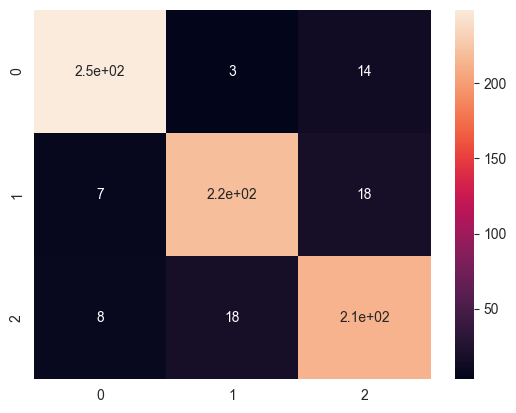

In [90]:
predictions_val = my_model1.predict(X_val1)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val1).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val1).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [91]:
predictions_val = my_model1.predict(X_val2[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[0 0 1 0 1 1 1 0 2 2]


In [92]:
pd.DataFrame(data=Y_val2[:10]).idxmax(axis=1)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    2
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       234
           1       0.92      0.90      0.91       255
           2       0.91      0.92      0.91       261

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



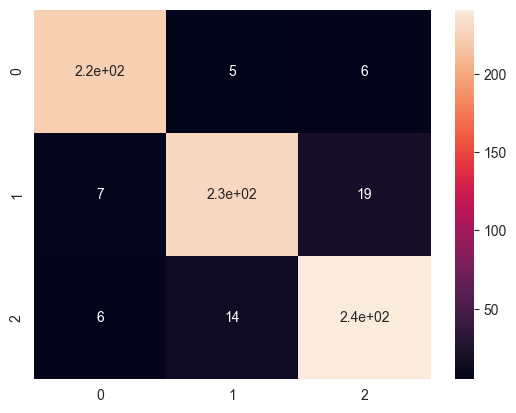

In [93]:
predictions_val = my_model1.predict(X_val2)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val2).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val2).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       500
           1       0.92      0.90      0.91       500
           2       0.89      0.91      0.90       500

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



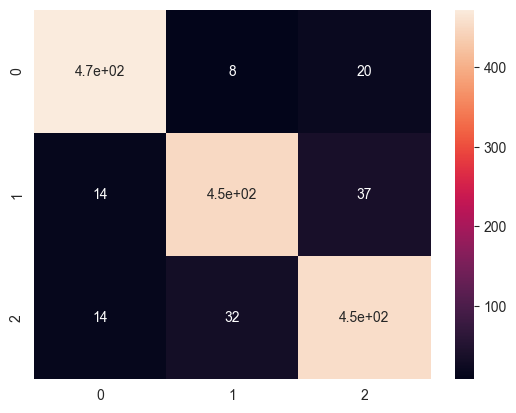

In [94]:
predictions_val = my_model1.predict(X_val)

cm = confusion_matrix(
    pd.DataFrame(data=labels_val).idxmax(axis=1),
    np.argmax(predictions_val, axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=labels_val).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

## Adding Scaling Layer

In [95]:
my_model2 = Sequential()
#Rescale layer
my_model2.add(
    tf.keras.layers.experimental.preprocessing.Rescaling(
        (1. / 255, ), input_shape=(76, 76, 3)))
# convolutional layer
my_model2.add(
    Conv2D(25,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           input_shape=(76, 76, 3)))
my_model2.add(MaxPool2D(pool_size=(2, 2)))
# flatten output of conv
my_model2.add(Flatten())
# hidden layer
my_model2.add(Dense(38, activation='relu'))
# output layer
my_model2.add(Dense(3, activation='softmax'))

In [96]:
tf.random.set_seed(100)
my_model2.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
my_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 76, 76, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 25)        700       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 25)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 34225)             0         
                                                                 
 dense_2 (Dense)             (None, 38)                1300588   
                                                                 
 dense_3 (Dense)             (None, 3)                 117       
                                                      

In [97]:
time_callback2 = TimeHistory()

In [98]:
history2 = my_model2.fit((X_train),
                         Y_train,
                         shuffle=True,
                         verbose=1,
                         epochs=50,
                         validation_steps=10,
                         batch_size=32,
                         validation_data=(X_test, Y_test),
                         callbacks=time_callback2)

Epoch 1/50
366/366 [==============================] - 8s 21ms/step - loss: 0.8165 - accuracy: 0.5766 - val_loss: 0.7528 - val_accuracy: 0.6219
Epoch 2/50
366/366 [==============================] - 7s 20ms/step - loss: 0.6334 - accuracy: 0.7060 - val_loss: 0.6376 - val_accuracy: 0.7312
Epoch 3/50
366/366 [==============================] - 7s 20ms/step - loss: 0.4754 - accuracy: 0.8204 - val_loss: 0.4821 - val_accuracy: 0.8125
Epoch 4/50
366/366 [==============================] - 7s 18ms/step - loss: 0.2482 - accuracy: 0.9104 - val_loss: 0.2779 - val_accuracy: 0.9062
Epoch 5/50
366/366 [==============================] - 7s 19ms/step - loss: 0.1417 - accuracy: 0.9488 - val_loss: 0.2328 - val_accuracy: 0.9156
Epoch 6/50
366/366 [==============================] - 7s 18ms/step - loss: 0.1034 - accuracy: 0.9637 - val_loss: 0.2409 - val_accuracy: 0.9219
Epoch 7/50
366/366 [==============================] - 7s 18ms/step - loss: 0.0723 - accuracy: 0.9765 - val_loss: 0.2108 - val_accuracy: 0.9344

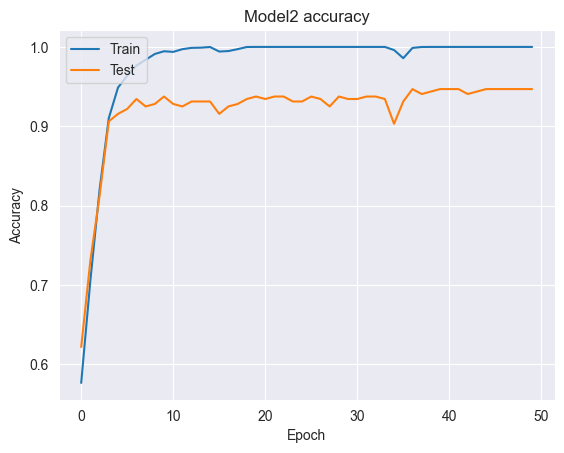

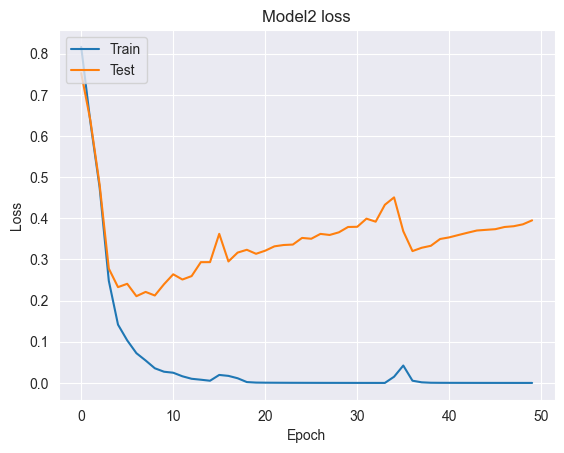

In [99]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [100]:
print("Max Accuracy:", max(history2.history['accuracy']))
print("Max Validated Accuracy:", max(history2.history['val_accuracy']))
print("Mean Accuracy:", statistics.mean(history2.history['accuracy']))
print("Mean Validated Accuracy:",
      statistics.mean(history2.history['val_accuracy']))
print("Mean Loss:", statistics.mean(history2.history['loss']))
print("Mean Validated Loss:", statistics.mean(history2.history['val_loss']))

Max Accuracy: 1.0
Max Validated Accuracy: 0.9468749761581421
Mean Accuracy: 0.9765430641174316
Mean Validated Accuracy: 0.9215624928474426
Mean Loss: 0.055872822609599096
Mean Validated Loss: 0.34931163877248766


In [101]:
predictions = my_model2.predict(X_test[:10])

In [102]:
import numpy as np

print(np.argmax(predictions, axis=1))

[0 1 0 1 1 2 0 1 2 0]


In [103]:
pd.DataFrame(data=Y_test[:10]).idxmax(axis=1)

0    0
1    1
2    0
3    2
4    1
5    2
6    0
7    1
8    1
9    0
dtype: int64

In [104]:
predictions_val = my_model2.predict(X_val1[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[1 2 1 0 1 0 1 0 1 2]


In [105]:
pd.DataFrame(data=Y_val1[:10]).idxmax(axis=1)

0    1
1    2
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       266
           1       0.94      0.95      0.94       245
           2       0.94      0.93      0.94       239

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



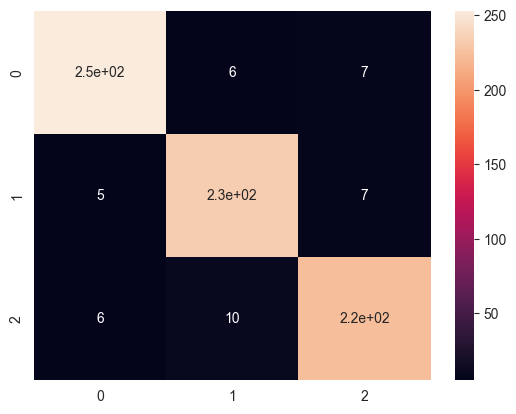

In [106]:
predictions_val = my_model2.predict(X_val1)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val1).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val1).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [107]:
predictions_val = my_model2.predict(X_val2[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[0 0 1 0 1 1 1 0 2 2]


In [108]:
pd.DataFrame(data=Y_val2[:10]).idxmax(axis=1)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    2
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       234
           1       0.95      0.91      0.93       255
           2       0.92      0.94      0.93       261

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750



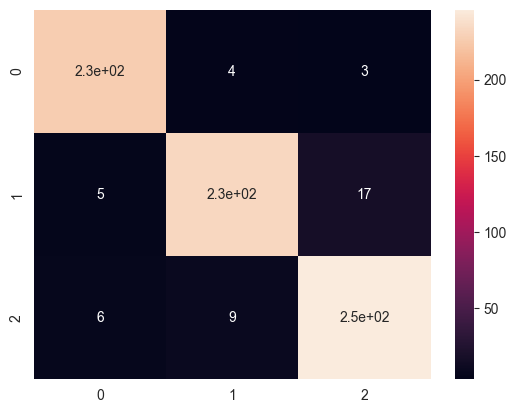

In [109]:
predictions_val = my_model2.predict(X_val2)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val2).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val2).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       500
           1       0.94      0.93      0.94       500
           2       0.93      0.94      0.94       500

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



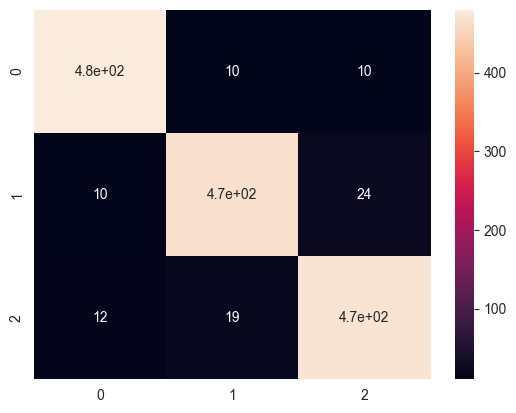

In [110]:
predictions_val = my_model2.predict(X_val)

cm = confusion_matrix(
    pd.DataFrame(data=labels_val).idxmax(axis=1),
    np.argmax(predictions_val, axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=labels_val).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

## Adding Three Data Augmentation Layers

In [111]:
my_model3 = Sequential()
#Data augmentation Layers
my_model3.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal",
        input_shape=(76, 76, 3),
        seed=100,
    ))
my_model3.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, seed=100))
my_model3.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=100))
#Rescale layer
my_model3.add(
    tf.keras.layers.experimental.preprocessing.Rescaling(
        (1. / 255, ), input_shape=(76, 76, 3)))
# convolutional layer
my_model3.add(
    Conv2D(25,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           input_shape=(76, 76, 3)))
my_model3.add(MaxPool2D(pool_size=(2, 2)))
# flatten output of conv
my_model3.add(Flatten())
# hidden layer
my_model3.add(Dense(38, activation='relu'))
# output layer
my_model3.add(Dense(3, activation='softmax'))

In [112]:
tf.random.set_seed(100)
my_model3.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
my_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 76, 76, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 76, 76, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 76, 76, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 76, 76, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 25)        700       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 25)       0         
 2D)                                                  

In [113]:
time_callback3 = TimeHistory()

In [114]:
history3 = my_model3.fit((X_train),
                         Y_train,
                         shuffle=True,
                         verbose=1,
                         epochs=50,
                         validation_steps=10,
                         batch_size=32,
                         validation_data=(X_test, Y_test),
                         callbacks=time_callback3)

Epoch 1/50
366/366 [==============================] - 10s 25ms/step - loss: 0.7007 - accuracy: 0.7002 - val_loss: 0.4192 - val_accuracy: 0.8313
Epoch 2/50
366/366 [==============================] - 9s 24ms/step - loss: 0.4201 - accuracy: 0.8396 - val_loss: 0.3756 - val_accuracy: 0.8531
Epoch 3/50
366/366 [==============================] - 9s 25ms/step - loss: 0.3581 - accuracy: 0.8627 - val_loss: 0.2833 - val_accuracy: 0.9000
Epoch 4/50
366/366 [==============================] - 9s 25ms/step - loss: 0.3176 - accuracy: 0.8774 - val_loss: 0.2575 - val_accuracy: 0.9062
Epoch 5/50
366/366 [==============================] - 9s 25ms/step - loss: 0.3033 - accuracy: 0.8888 - val_loss: 0.2378 - val_accuracy: 0.9250
Epoch 6/50
366/366 [==============================] - 9s 25ms/step - loss: 0.2698 - accuracy: 0.8974 - val_loss: 0.3082 - val_accuracy: 0.8844
Epoch 7/50
366/366 [==============================] - 9s 25ms/step - loss: 0.2525 - accuracy: 0.9035 - val_loss: 0.2061 - val_accuracy: 0.931

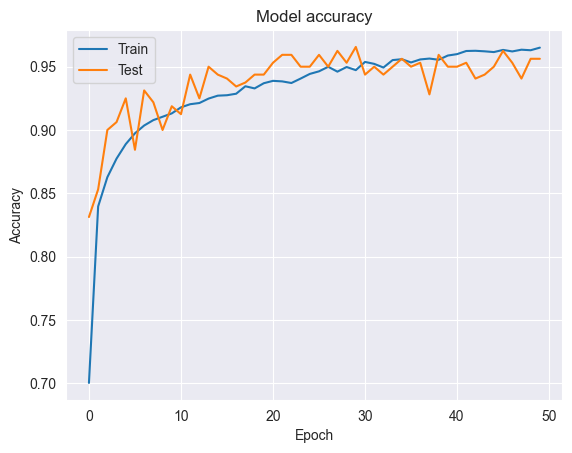

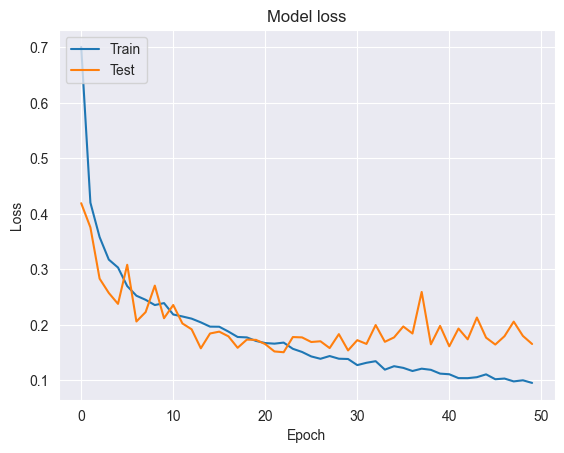

In [115]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [116]:
print("Max Accuracy:", max(history3.history['accuracy']))
print("Max Validated Accuracy:", max(history3.history['val_accuracy']))
print("Mean Accuracy:", statistics.mean(history3.history['accuracy']))
print("Mean Validated Accuracy:",
      statistics.mean(history3.history['val_accuracy']))
print("Mean Loss:", statistics.mean(history3.history['loss']))
print("Mean Validated Loss:", statistics.mean(history3.history['val_loss']))

Max Accuracy: 0.9650546908378601
Max Validated Accuracy: 0.965624988079071
Mean Accuracy: 0.9316678082942963
Mean Validated Accuracy: 0.9380000019073487
Mean Loss: 0.1815258364379406
Mean Validated Loss: 0.19997070848941803


In [117]:
predictions = my_model3.predict(X_test[:10])

In [118]:
import numpy as np

print(np.argmax(predictions, axis=1))

[0 1 0 1 1 2 0 1 1 0]


In [119]:
pd.DataFrame(data=Y_test[:10]).idxmax(axis=1)

0    0
1    1
2    0
3    2
4    1
5    2
6    0
7    1
8    1
9    0
dtype: int64

In [120]:
predictions_val = my_model3.predict(X_val1[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[1 0 1 0 1 0 1 0 1 2]


In [121]:
pd.DataFrame(data=Y_val1[:10]).idxmax(axis=1)

0    1
1    2
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       266
           1       0.96      0.95      0.96       245
           2       0.95      0.93      0.94       239

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



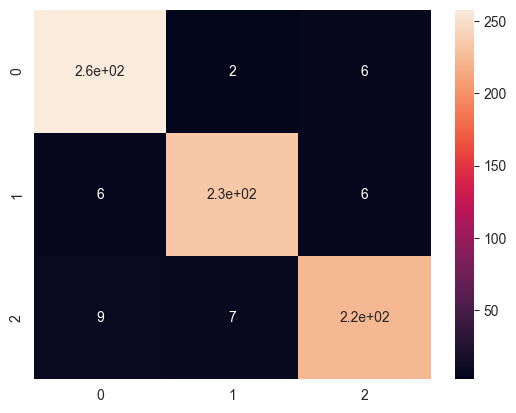

In [122]:
predictions_val = my_model3.predict(X_val1)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val1).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val1).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [123]:
predictions_val = my_model3.predict(X_val2[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[0 0 1 0 1 1 1 0 2 2]


In [124]:
pd.DataFrame(data=Y_val2[:10]).idxmax(axis=1)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    2
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       234
           1       0.97      0.92      0.95       255
           2       0.94      0.97      0.95       261

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



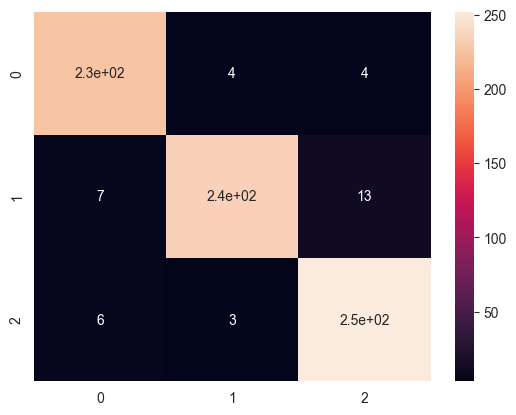

In [125]:
predictions_val = my_model3.predict(X_val2)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val2).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val2).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       500
           1       0.97      0.94      0.95       500
           2       0.94      0.95      0.95       500

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



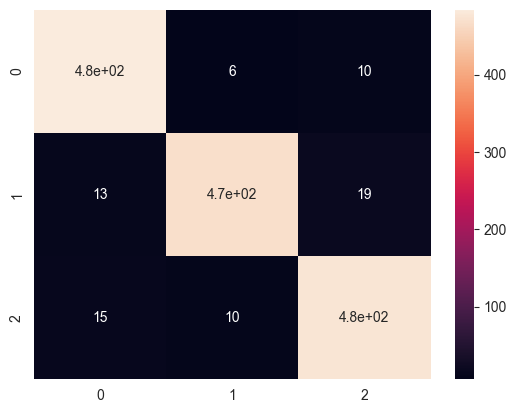

In [126]:
predictions_val = my_model3.predict(X_val)

cm = confusion_matrix(
    pd.DataFrame(data=labels_val).idxmax(axis=1),
    np.argmax(predictions_val, axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=labels_val).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

## Adding Droput Layer

In [127]:
my_model4 = Sequential()
#Data augmentation Layers
my_model4.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                          input_shape=(76, 76,
                                                                       3),
                                                          seed=100))
my_model4.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, seed=100))
my_model4.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=100))
#Rescale layer
my_model4.add(
    tf.keras.layers.experimental.preprocessing.Rescaling(
        (1. / 255, ), input_shape=(76, 76, 3)))
# convolutional layer
my_model4.add(
    Conv2D(25,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           input_shape=(76, 76, 3)))
my_model4.add(MaxPool2D(pool_size=(2, 2)))
# droput layer
my_model4.add(Dropout(0.25))
# flatten output of conv
my_model4.add(Flatten())
# hidden layer
my_model4.add(Dense(38, activation='relu'))
# output layer
my_model4.add(Dense(3, activation='softmax'))

In [128]:
tf.random.set_seed(100)
my_model4.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
my_model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 76, 76, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 76, 76, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 76, 76, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 76, 76, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 25)        700       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 25)       0         
 2D)                                                  

In [129]:
time_callback4 = TimeHistory()

In [130]:
history4 = my_model4.fit((X_train),
                         Y_train,
                         shuffle=True,
                         verbose=1,
                         epochs=50,
                         validation_steps=10,
                         batch_size=32,
                         validation_data=(X_test, Y_test),
                         callbacks=time_callback4)

Epoch 1/50
366/366 [==============================] - 12s 30ms/step - loss: 0.7714 - accuracy: 0.6597 - val_loss: 0.4886 - val_accuracy: 0.8219
Epoch 2/50
366/366 [==============================] - 10s 28ms/step - loss: 0.4738 - accuracy: 0.8164 - val_loss: 0.3838 - val_accuracy: 0.8500
Epoch 3/50
366/366 [==============================] - 10s 29ms/step - loss: 0.3953 - accuracy: 0.8479 - val_loss: 0.3032 - val_accuracy: 0.8844
Epoch 4/50
366/366 [==============================] - 10s 28ms/step - loss: 0.3487 - accuracy: 0.8674 - val_loss: 0.2745 - val_accuracy: 0.8844
Epoch 5/50
366/366 [==============================] - 10s 27ms/step - loss: 0.3311 - accuracy: 0.8745 - val_loss: 0.2626 - val_accuracy: 0.9250
Epoch 6/50
366/366 [==============================] - 10s 27ms/step - loss: 0.3034 - accuracy: 0.8819 - val_loss: 0.2958 - val_accuracy: 0.8844
Epoch 7/50
366/366 [==============================] - 10s 27ms/step - loss: 0.2822 - accuracy: 0.8945 - val_loss: 0.2518 - val_accuracy:

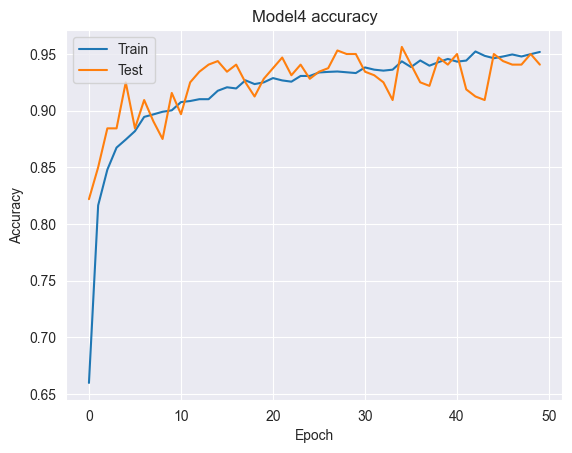

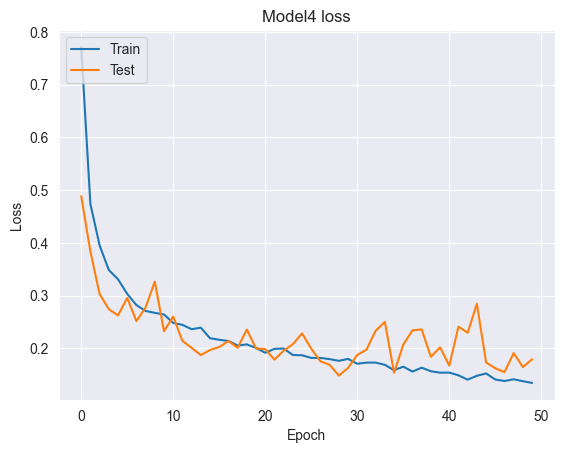

In [131]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model4 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [132]:
print("Max Accuracy:", max(history4.history['accuracy']))
print("Max Validated Accuracy:", max(history4.history['val_accuracy']))
print("Mean Accuracy:", statistics.mean(history4.history['accuracy']))
print("Mean Validated Accuracy:",
      statistics.mean(history4.history['val_accuracy']))
print("Mean Loss:", statistics.mean(history4.history['loss']))
print("Mean Validated Loss:", statistics.mean(history4.history['val_loss']))

Max Accuracy: 0.9522385597229004
Max Validated Accuracy: 0.956250011920929
Mean Accuracy: 0.918016060590744
Mean Validated Accuracy: 0.9243750011920929
Mean Loss: 0.21772821754217148
Mean Validated Loss: 0.22225646793842316


In [133]:
predictions = my_model4.predict(X_test[:10])

In [134]:
import numpy as np

print(np.argmax(predictions, axis=1))

[0 1 0 1 1 2 0 1 1 0]


In [135]:
pd.DataFrame(data=Y_test[:10]).idxmax(axis=1)

0    0
1    1
2    0
3    2
4    1
5    2
6    0
7    1
8    1
9    0
dtype: int64

In [136]:
predictions_val = my_model4.predict(X_val1[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[1 0 1 0 1 0 1 0 1 2]


In [137]:
pd.DataFrame(data=Y_val1[:10]).idxmax(axis=1)

0    1
1    2
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       266
           1       0.97      0.95      0.96       245
           2       0.94      0.93      0.94       239

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



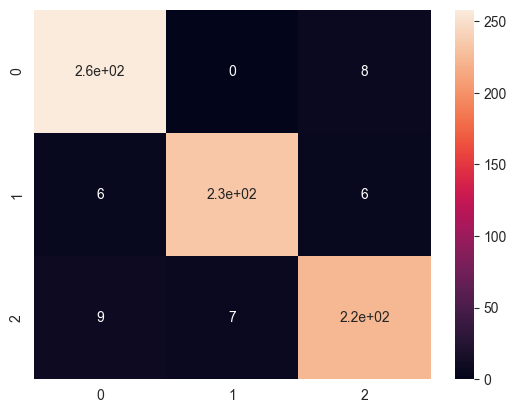

In [138]:
predictions_val = my_model4.predict(X_val1)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val1).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val1).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [139]:
predictions_val = my_model4.predict(X_val2[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[0 0 1 0 1 1 1 0 2 2]


In [140]:
pd.DataFrame(data=Y_val2[:10]).idxmax(axis=1)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    2
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       234
           1       0.97      0.91      0.94       255
           2       0.93      0.95      0.94       261

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750



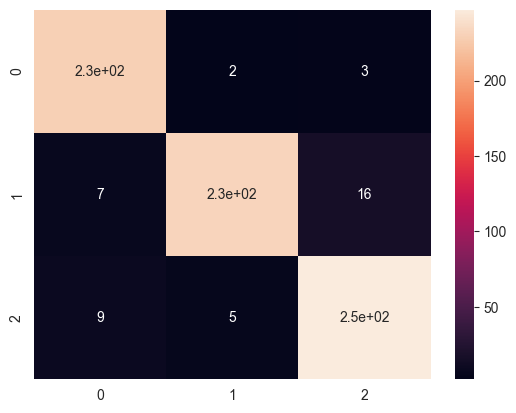

In [141]:
predictions_val = my_model4.predict(X_val2)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val2).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val2).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       500
           1       0.97      0.93      0.95       500
           2       0.93      0.94      0.94       500

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



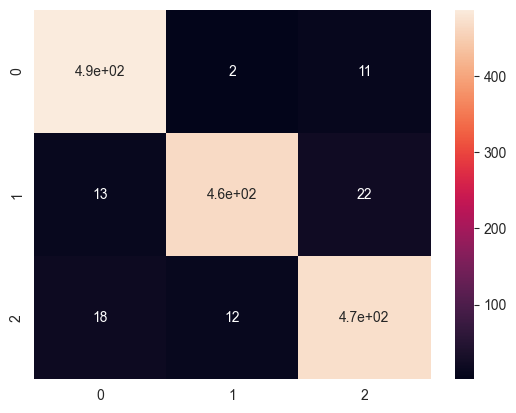

In [142]:
predictions_val = my_model4.predict(X_val)

cm = confusion_matrix(
    pd.DataFrame(data=labels_val).idxmax(axis=1),
    np.argmax(predictions_val, axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=labels_val).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

## Adding Two More Conv and Maxpool Layers

In [143]:
my_model5 = Sequential()
#Data augmentation Layers
my_model5.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                          input_shape=(76, 76,
                                                                       3),
                                                          seed=100))
my_model5.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, seed=100))
my_model5.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=100))
#Rescale layer
my_model5.add(
    tf.keras.layers.experimental.preprocessing.Rescaling(
        (1. / 255, ), input_shape=(76, 76, 3)))
# convolutional layer
my_model5.add(
    Conv2D(50,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           input_shape=(76, 76, 3)))
my_model5.add(MaxPool2D(pool_size=(2, 2)))
# droput layer
my_model5.add(Dropout(0.25))
# convolutional layer
my_model5.add(
    Conv2D(25,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu'))
my_model5.add(MaxPool2D(pool_size=(2, 2)))
# flatten output of conv
my_model5.add(Flatten())
# hidden layer
my_model5.add(Dense(38, activation='relu'))
# output layer
my_model5.add(Dense(3, activation='softmax'))

In [144]:
tf.random.set_seed(100)
my_model5.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
my_model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 76, 76, 3)         0         
                                                                 
 random_rotation_2 (RandomRo  (None, 76, 76, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 76, 76, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 76, 76, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 74, 74, 50)        1400      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 50)       0         
 2D)                                                  

In [145]:
time_callback5 = TimeHistory()

In [146]:
history5 = my_model5.fit((X_train),
                         Y_train,
                         shuffle=True,
                         verbose=1,
                         epochs=50,
                         validation_steps=10,
                         batch_size=32,
                         validation_data=(X_test, Y_test),
                         callbacks=time_callback5)

Epoch 1/50
366/366 [==============================] - 17s 41ms/step - loss: 0.6826 - accuracy: 0.7026 - val_loss: 0.4123 - val_accuracy: 0.8375
Epoch 2/50
366/366 [==============================] - 15s 40ms/step - loss: 0.3322 - accuracy: 0.8754 - val_loss: 0.2197 - val_accuracy: 0.9375
Epoch 3/50
366/366 [==============================] - 14s 39ms/step - loss: 0.2569 - accuracy: 0.9026 - val_loss: 0.1783 - val_accuracy: 0.9312
Epoch 4/50
366/366 [==============================] - 14s 39ms/step - loss: 0.2290 - accuracy: 0.9163 - val_loss: 0.1371 - val_accuracy: 0.9625
Epoch 5/50
366/366 [==============================] - 14s 39ms/step - loss: 0.2111 - accuracy: 0.9219 - val_loss: 0.1624 - val_accuracy: 0.9375
Epoch 6/50
366/366 [==============================] - 15s 40ms/step - loss: 0.1939 - accuracy: 0.9266 - val_loss: 0.2405 - val_accuracy: 0.9000
Epoch 7/50
366/366 [==============================] - 16s 43ms/step - loss: 0.1789 - accuracy: 0.9344 - val_loss: 0.2390 - val_accuracy:

In [184]:
history5 = my_model5.fit((X_train),
                         Y_train,
                         shuffle=True,
                         verbose=1,
                         epochs=50,
                         validation_steps=10,
                         batch_size=32,
                         validation_data=(X_test, Y_test),
                         callbacks=time_callback5,
                         seed=100)

TypeError: Model.fit() got an unexpected keyword argument 'seed'

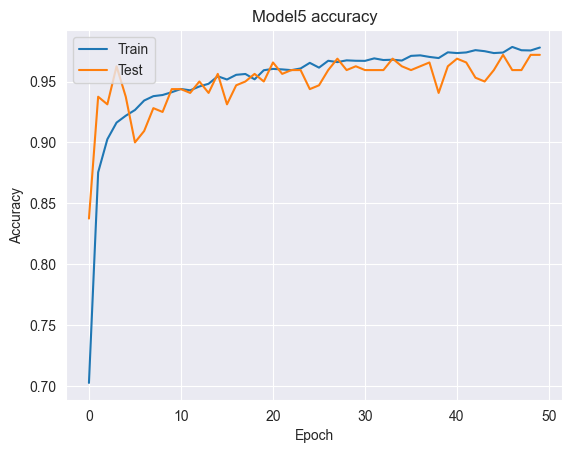

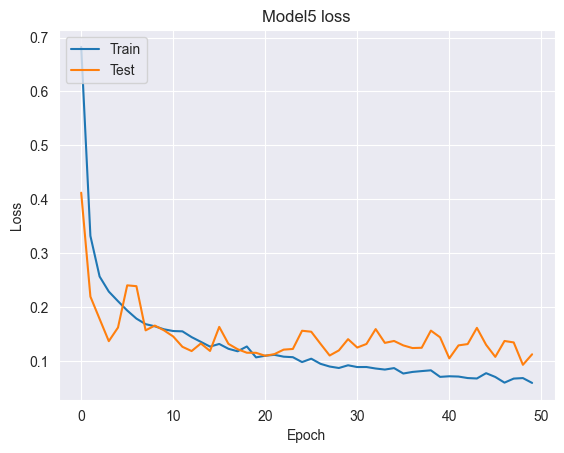

In [147]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model5 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

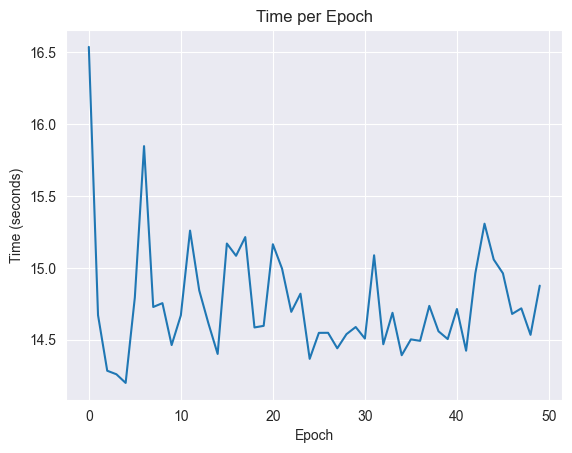

In [148]:
plt.plot(time_callback5.times)
plt.title('Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.show()

In [149]:
print("Max Accuracy:", max(history5.history['accuracy']))
print("Max Validated Accuracy:", max(history5.history['val_accuracy']))
print("Mean Accuracy:", statistics.mean(history5.history['accuracy']))
print("Mean Validated Accuracy:",
      statistics.mean(history5.history['val_accuracy']))
print("Mean Loss:", statistics.mean(history5.history['loss']))
print("Mean Validated Loss:", statistics.mean(history5.history['val_loss']))

Max Accuracy: 0.978383481502533
Max Validated Accuracy: 0.971875011920929
Mean Accuracy: 0.9517652082443238
Mean Validated Accuracy: 0.9498125028610229
Mean Loss: 0.12840155608952045
Mean Validated Loss: 0.14505125626921653


In [150]:
predictions = my_model5.predict(X_test[:10])

In [151]:
import numpy as np

print(np.argmax(predictions, axis=1))

[0 1 0 2 1 2 0 1 1 0]


In [152]:
pd.DataFrame(data=Y_test[:10]).idxmax(axis=1)

0    0
1    1
2    0
3    2
4    1
5    2
6    0
7    1
8    1
9    0
dtype: int64

In [153]:
predictions_val = my_model5.predict(X_val1[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[1 0 1 0 1 0 1 0 1 2]


In [154]:
pd.DataFrame(data=Y_val1[:10]).idxmax(axis=1)

0    1
1    2
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       266
           1       0.98      0.98      0.98       245
           2       0.97      0.96      0.96       239

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



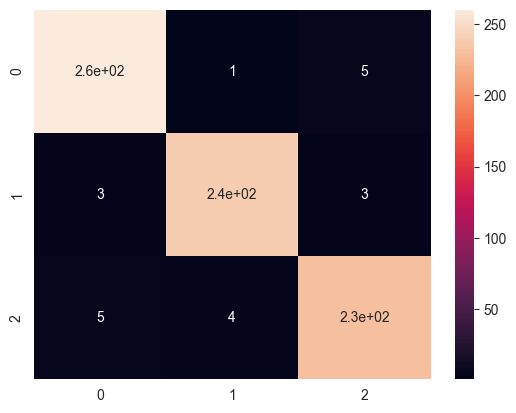

In [155]:
predictions_val = my_model5.predict(X_val1)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val1).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val1).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [156]:
predictions_val = my_model5.predict(X_val2[:10])
import numpy as np

print(np.argmax(predictions_val, axis=1))

[0 0 1 0 1 1 1 0 2 2]


In [157]:
pd.DataFrame(data=Y_val2[:10]).idxmax(axis=1)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    2
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       234
           1       0.97      0.95      0.96       255
           2       0.97      0.96      0.97       261

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



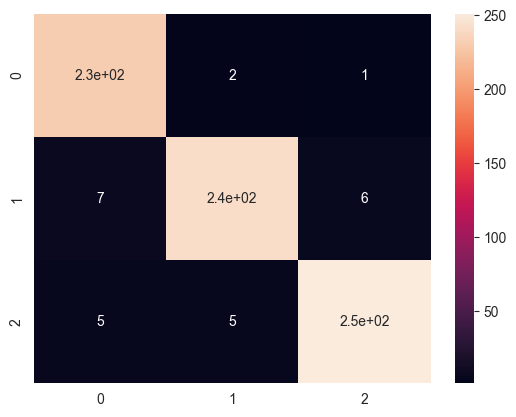

In [158]:
predictions_val = my_model5.predict(X_val2)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val2).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val2).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       500
           1       0.98      0.96      0.97       500
           2       0.97      0.96      0.97       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



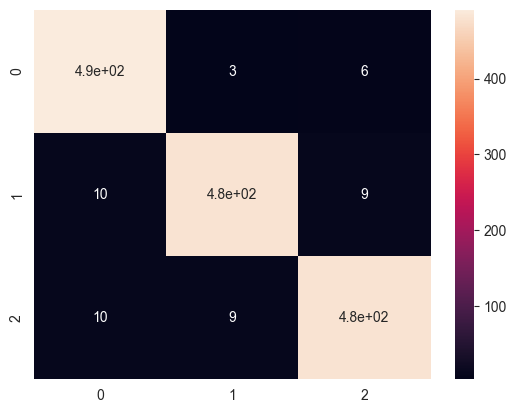

In [159]:
predictions_val = my_model5.predict(X_val)

cm = confusion_matrix(
    pd.DataFrame(data=labels_val).idxmax(axis=1),
    np.argmax(predictions_val, axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=labels_val).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

## Train in CPU test

In [160]:
my_model6 = Sequential()
#Data augmentation Layers
my_model6.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                          input_shape=(76, 76,
                                                                       3),
                                                          seed=100))
my_model6.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, seed=100))
my_model6.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=100))
#Rescale layer
my_model6.add(
    tf.keras.layers.experimental.preprocessing.Rescaling(
        (1. / 255, ), input_shape=(76, 76, 3)))
# convolutional layer
my_model6.add(
    Conv2D(50,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           input_shape=(76, 76, 3)))
my_model6.add(MaxPool2D(pool_size=(2, 2)))
# droput layer
my_model6.add(Dropout(0.25))
# convolutional layer
my_model6.add(
    Conv2D(25,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding='valid',
           activation='relu'))
my_model6.add(MaxPool2D(pool_size=(2, 2)))
# flatten output of conv
my_model6.add(Flatten())
# hidden layer
my_model6.add(Dense(38, activation='relu'))
# output layer
my_model6.add(Dense(3, activation='softmax'))

In [161]:
tf.random.set_seed(100)
my_model6.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
my_model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 76, 76, 3)         0         
                                                                 
 random_rotation_3 (RandomRo  (None, 76, 76, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 76, 76, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 76, 76, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 74, 74, 50)        1400      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 50)       0         
 2D)                                                  

In [162]:
time_callback6 = TimeHistory()

In [163]:
with tf.device('/cpu:0'):
    history6 = my_model6.fit(X_train,
                             Y_train,
                             shuffle=True,
                             verbose=1,
                             epochs=50,
                             batch_size=32,
                             validation_data=(X_test, Y_test),
                             workers=-1,
                             use_multiprocessing=True,
                             callbacks=time_callback6)

Epoch 1/50
366/366 [==============================] - 100s 268ms/step - loss: 0.7094 - accuracy: 0.6915 - val_loss: 0.3491 - val_accuracy: 0.8660
Epoch 2/50
366/366 [==============================] - 90s 245ms/step - loss: 0.3420 - accuracy: 0.8717 - val_loss: 0.2167 - val_accuracy: 0.9200
Epoch 3/50
366/366 [==============================] - 90s 245ms/step - loss: 0.2657 - accuracy: 0.8982 - val_loss: 0.1819 - val_accuracy: 0.9306
Epoch 4/50
366/366 [==============================] - 89s 244ms/step - loss: 0.2406 - accuracy: 0.9098 - val_loss: 0.1753 - val_accuracy: 0.9402
Epoch 5/50
366/366 [==============================] - 91s 248ms/step - loss: 0.2238 - accuracy: 0.9158 - val_loss: 0.1587 - val_accuracy: 0.9392
Epoch 6/50
366/366 [==============================] - 86s 236ms/step - loss: 0.2000 - accuracy: 0.9265 - val_loss: 0.2029 - val_accuracy: 0.9299
Epoch 7/50
366/366 [==============================] - 88s 239ms/step - loss: 0.1841 - accuracy: 0.9304 - val_loss: 0.2409 - val_a

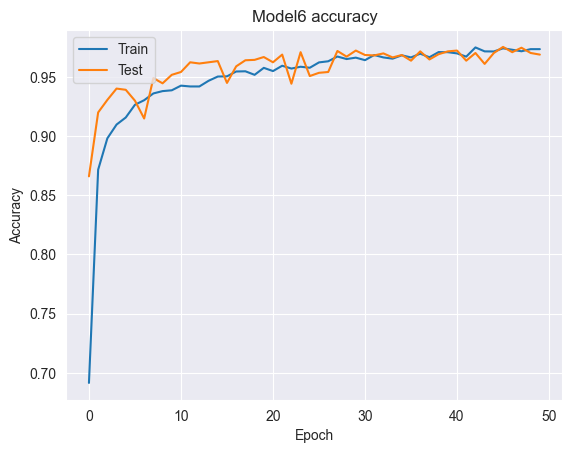

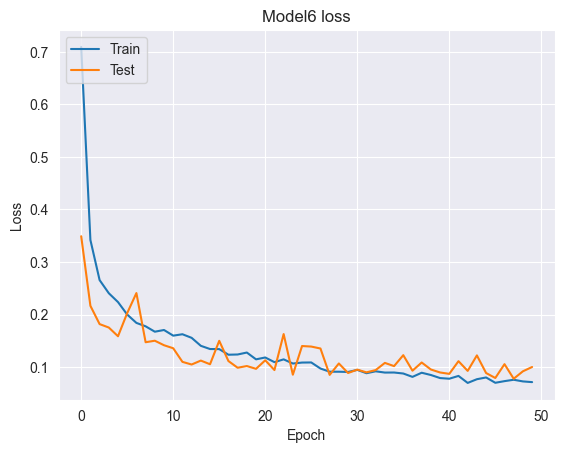

In [164]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model6 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model6 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

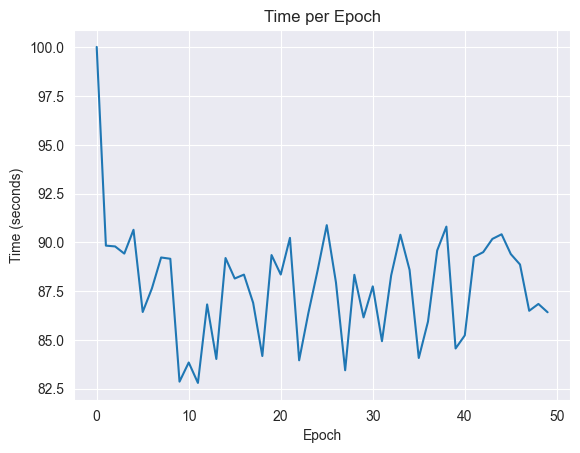

In [165]:
plt.plot(time_callback6.times)
plt.title('Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.show()

In [166]:
print("Max Accuracy:", max(history6.history['accuracy']))
print("Max Validated Accuracy:", max(history6.history['val_accuracy']))
print("Mean Accuracy:", statistics.mean(history6.history['accuracy']))
print("Mean Validated Accuracy:",
      statistics.mean(history6.history['val_accuracy']))
print("Mean Loss:", statistics.mean(history6.history['loss']))
print("Mean Validated Loss:", statistics.mean(history6.history['val_loss']))

Max Accuracy: 0.9749658107757568
Max Validated Accuracy: 0.9753930568695068
Mean Accuracy: 0.9492259061336518
Mean Validated Accuracy: 0.9577375292778015
Mean Loss: 0.13450142472982407
Mean Validated Loss: 0.12401161774992943


In [167]:
predictions = my_model6.predict(X_test[:10])

In [168]:
import numpy as np

print(np.argmax(predictions, axis=1))

[0 1 0 2 1 2 0 1 2 0]


In [169]:
pd.DataFrame(data=Y_test[:10]).idxmax(axis=1)

0    0
1    1
2    0
3    2
4    1
5    2
6    0
7    1
8    1
9    0
dtype: int64

In [170]:
predictions_val = my_model6.predict(X_val1[:10])

import numpy as np

print(np.argmax(predictions_val, axis=1))

[1 0 1 0 1 0 1 0 1 2]


In [171]:
pd.DataFrame(data=Y_val1[:10]).idxmax(axis=1)

0    1
1    2
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       266
           1       0.98      0.97      0.97       245
           2       0.96      0.97      0.96       239

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



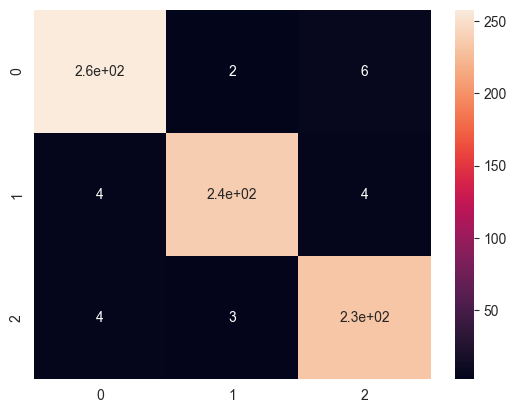

In [172]:
predictions_val = my_model6.predict(X_val1)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val1).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val1).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [173]:
predictions_val = my_model6.predict(X_val2[:10])
import numpy as np

print(np.argmax(predictions_val, axis=1))

[0 0 1 0 1 1 1 0 2 2]


In [174]:
pd.DataFrame(data=Y_val2[:10]).idxmax(axis=1)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    2
9    2
dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       234
           1       0.96      0.93      0.95       255
           2       0.93      0.97      0.95       261

    accuracy                           0.95       750
   macro avg       0.96      0.95      0.96       750
weighted avg       0.96      0.95      0.95       750



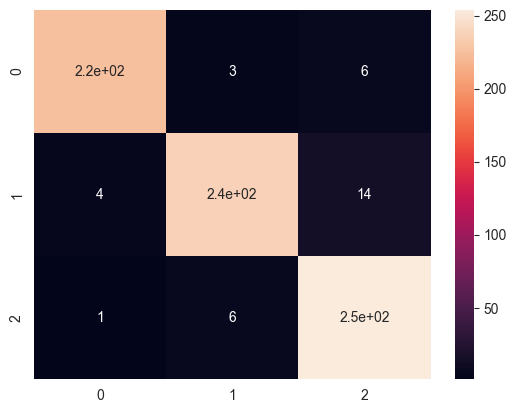

In [175]:
predictions_val = my_model6.predict(X_val2)

cm = confusion_matrix(
    pd.DataFrame(data=Y_val2).idxmax(axis=1), np.argmax(predictions_val,
                                                        axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=Y_val2).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       500
           1       0.97      0.95      0.96       500
           2       0.94      0.97      0.96       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



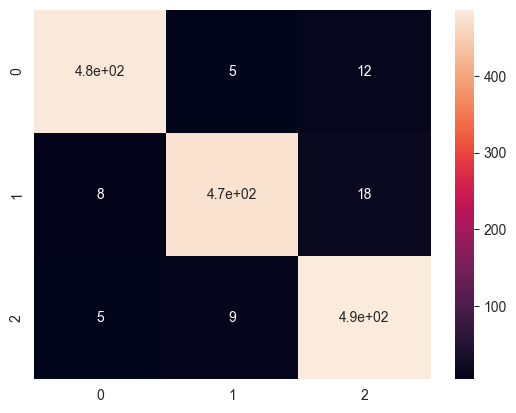

In [176]:
predictions_val = my_model6.predict(X_val)

cm = confusion_matrix(
    pd.DataFrame(data=labels_val).idxmax(axis=1),
    np.argmax(predictions_val, axis=1))

sns.heatmap(cm, annot=True)

print(
    classification_report(
        pd.DataFrame(data=labels_val).idxmax(axis=1),
        np.argmax(predictions_val, axis=1)))

In [177]:
# Create a DataFrame to store validation accuracy data for each model
histdf = pd.DataFrame()
histdf['Epoch'] = range(1, len(history1.history['val_accuracy']) + 1)
histdf['Model 1'] = history1.history['val_accuracy']
histdf['Model 2'] = history2.history['val_accuracy']
histdf['Model 3'] = history3.history['val_accuracy']
histdf['Model 4'] = history4.history['val_accuracy']
histdf['Model 5'] = history5.history['val_accuracy']
histdf['Model 6'] = history6.history['val_accuracy']

# create graph
fig = px.line(histdf,
              x='Epoch',
              y=histdf.columns[1:],
              title='Models Validated Accuracy',
              labels={
                  'Epoch': 'Epoch',
                  'value': 'Accuracy',
                  'variable': 'Model'
              },
              template='plotly_dark')

# Show the plot
fig.show()

In [182]:
# Create a DataFrame to store validation loss data for each model
histdf = pd.DataFrame()
histdf['Epoch'] = range(1, len(history1.history['val_loss']) + 1)
histdf['Model 1'] = history1.history['val_loss']
histdf['Model 2'] = history2.history['val_loss']
histdf['Model 3'] = history3.history['val_loss']
histdf['Model 4'] = history4.history['val_loss']
histdf['Model 5'] = history5.history['val_loss']
histdf['Model 6'] = history6.history['val_loss']

# create graph
fig = px.line(histdf,
              x='Epoch',
              y=histdf.columns[1:],
              title='Models Validated Loss',
              labels={
                  'Epoch': 'Epoch',
                  'value': 'Loss',
                  'variable': 'Model'
              },
              template='plotly_dark')

# Show the plot
fig.show()

In [185]:
# Create a DataFrame to store time for each model
histdf = pd.DataFrame()
histdf['Epoch'] = range(1, len(history1.history['val_loss']) + 1)
histdf['Model 1'] = time_callback1.times
histdf['Model 2'] = time_callback2.times
histdf['Model 3'] = time_callback3.times
histdf['Model 4'] = time_callback4.times
histdf['Model 5'] = time_callback5.times
histdf['Model 6'] = time_callback6.times

# create graph
fig = px.line(histdf,
              x='Epoch',
              y=histdf.columns[1:],
              title='Models Time per Epoch',
              labels={
                  'Epoch': 'Epoch',
                  'value': 'Time in seconds',
                  'variable': 'Model'
              },
              template='plotly_dark')

# Show the plot
fig.show()